In [1]:
# This notebook shows how to use this repo
# choose 'cpu', 'cuda', or your devices; a gpu is recommended

import torch
torch.set_default_device('cuda')
torch.set_default_dtype(torch.float64)
torch.manual_seed(1642)

# load the preprocessed dataset
labels, \
tokens, \
dictionary, \
tokens_bow, \
tokens_sparse \
= \
torch.load("reuters_dataset/reuters_coo.pt",
           map_location='cuda',
           weights_only=False)

In [2]:
# the number of words in one of the documents
# before third filtering, this is an empty list
print(len(tokens[69]))
# total number of documents
print(len(labels))

117
7460


In [3]:
from collections import Counter

label_counts = Counter(labels)

print(label_counts)

Counter({'earn': 3900, 'acq': 2289, 'crude': 370, 'trade': 324, 'money-fx': 306, 'interest': 271})


In [ ]:
# compute a ldta model

from lda import LDA as LDA
from dists import Dirichlet as Dir, \
                  Beta_Liouville as BL, \
                  Generalized_Dirichlet as GDir

# K: the number of topics
# prior_cls: Dir, BL, or GDir
# inference: MFVI (lda.fit()) or EP (lda.fit_ep())
lda = LDA(tokens_sparse, K=10, prior_cls=Dir)
lda.fit(est_prior=True)

# lda_ep = LDA(tokens_sparse, K=10, prior_cls=Dir)
# lda_ep.fit_ep(est_prior=True)

**** em iteration 1 ****
elbo = -2758385.6729764896;    converged = 0.18751803010400073

**** em iteration 2 ****
elbo = -2712652.695142494;    converged = 0.016579616941182318

**** em iteration 3 ****
elbo = -2660602.508577454;    converged = 0.01918792872314455

**** em iteration 4 ****
elbo = -2611884.656410896;    converged = 0.018310834485608933

**** em iteration 5 ****
elbo = -2575432.144398445;    converged = 0.013956401911921485

**** em iteration 6 ****
elbo = -2550126.264035327;    converged = 0.009825877345733258

**** em iteration 7 ****
elbo = -2532386.1904373965;    converged = 0.006956547151456897

**** em iteration 8 ****
elbo = -2519960.831232574;    converged = 0.004906581488930235

**** em iteration 9 ****
elbo = -2511190.8584471387;    converged = 0.0034802020240709635

**** em iteration 10 ****
elbo = -2504849.1271700086;    converged = 0.002525388006967999

**** em iteration 11 ****
elbo = -2500073.89769901;    converged = 0.0019063940495264852

**** em iteratio

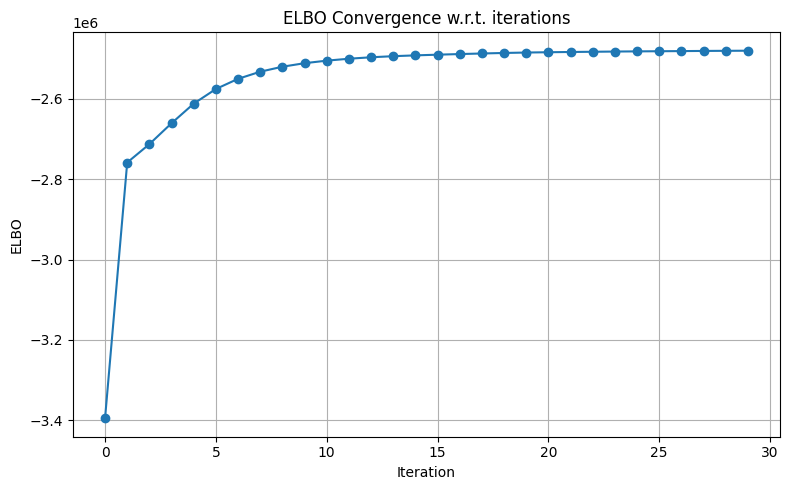

In [5]:
import matplotlib.pyplot as plt

# Plot ELBO over iterations
plt.figure(figsize=(8, 5))
plt.plot(lda.elbo_itr, marker='o', linestyle='-')
plt.title("ELBO Convergence w.r.t. iterations")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Now, we starts the classification
import numpy as np

X = lda.sufficient.post_zetas.mean_theta().detach().cpu().numpy()  # (M, K)

In [7]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)  # shape (M,)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=10
)

In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Classification accuracy: {acc:.4f}")

# detailed report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification accuracy: 0.9129
              precision    recall  f1-score   support

         acq       0.91      0.93      0.92       458
       crude       0.97      0.86      0.91        74
        earn       0.95      0.95      0.95       780
    interest       0.67      0.69      0.68        54
    money-fx       0.68      0.69      0.68        61
       trade       0.84      0.80      0.82        65

    accuracy                           0.91      1492
   macro avg       0.84      0.82      0.83      1492
weighted avg       0.91      0.91      0.91      1492



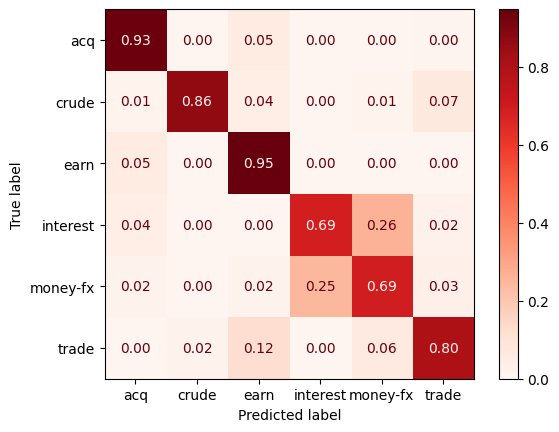

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# draw a confusion matrix
# please adjust the number of topics for better result
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred, 
    display_labels=label_encoder.classes_,
    cmap="Reds",
    normalize='true',
    values_format='.2f'
    )